# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

## Exploring data sets

In [152]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [124]:
CHURN_IND =churn['CHURN_IND']
set(CHURN_IND)

{0, 1}

In [125]:
churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,28416.000000,28416.000000,28416.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029,0.014640,0.191125,0.007038
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041,0.120108,0.393194,0.083600
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000,0.000000,0.000000,0.000000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000,0.000000,0.000000,0.000000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000,0.000000,0.000000,0.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000,1.000000,1.000000,1.000000


## Dropping required and clear outlier data/fields

<AxesSubplot:xlabel='CUST_ID'>

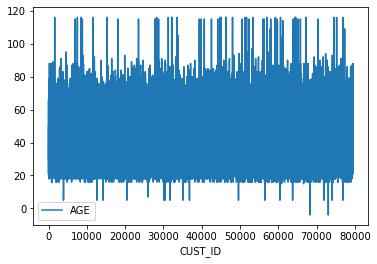

In [126]:
churn.plot(y = 'AGE', x = 'CUST_ID')

From the data above, we can see there are negative ages. This is imposible as a person cannot have an age of -4 for example. Thus, we must drop age values below zero. In addition we were asked in the introduction to drop 'RECON' fields, so we will do that as well

In [127]:
# dropping age < 0 and RECON fields
churn_aclean = churn.drop(churn.index[(churn['AGE'] < 0)])
churned = churn_aclean.drop(['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1)
# check if drop worked
churned.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46204.000000,46204.000000,46204.000000,46128.000000,46204.000000,46204.000000,46204.000000,46204.000000,46204.000000,46204.000000,46204.000000,46204.000000
mean,42333.969959,45.874253,1.555731,41.413805,50.318436,51.365724,10.846442,8.237469,20.350186,15.250108,0.385010,75.189707
std,22100.118621,33.078586,0.835539,15.261128,51.926649,20.854898,9.769580,8.341481,8.034229,10.982891,0.486603,73.520087
min,1.000000,0.000000,1.000000,5.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,24950.500000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,43259.500000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,61131.250000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


# Step 1
## Data processing - Drop the customer ID column and all the text columns, you can involve more preprocessing

> steps:
> 1. Find and drop redundant data
> 2. Drop the customer ID column and all the text columns

### Find and drop redundant data

In [128]:
# Find if there are any NaN values in data
churned.isna().sum()

CUST_ID                          0
ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [129]:
churned.shape

(46204, 18)

In [130]:
# Clean data by dropping NaN values
churned = churned.dropna()
# Check shape size to confirm dropped values
churned.shape

(46127, 18)

### Drop all the text columns

In [141]:
# Drop the customer ID column and all the text columns
churned_dtext = churned.drop(['CFU', 'CONTRACT_STATUS', 'COUNTRY_METRO_REGION', 'STATE', 'HANDSET_USED_BRAND', 'BYO_PLAN_STATUS'], axis=1)
churned_dtext.head()
print(churned_dtext.shape)
churned_dtext.describe()

(46127, 12)


,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000,46127.000000
mean,42336.772498,45.886856,1.554426,41.413576,50.364234,51.361234,10.850890,8.235090,20.351118,15.253192,0.385067,75.169090
std,22102.538850,33.073946,0.834363,15.261213,51.943989,20.854056,9.771842,8.339843,8.032833,10.981573,0.486616,73.393772
min,1.000000,0.000000,1.000000,5.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,24950.000000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,43262.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,61136.500000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


# Step 2 
## Data preparation, Split data into training set and test set, design the input variables X and precition variable Y

In [142]:
# Splitting data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(churned_dtext, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(36901, 12)
(9226, 12)


# Step 3
## Model training , train a logistic regression classifier on train data

In [167]:
# Getting input data and targets for building prediction model
X_train = train.drop(['CHURN_IND', 'CUST_ID'], axis=1)
y_train = train['CHURN_IND']

X_test = test.drop(['CHURN_IND', 'CUST_ID'], axis=1)
y_test = test['CHURN_IND']
# see the effect of the drop
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shape:  (36901, 10)
y_train shape:  (36901,)
X_test shape:  (9226, 10)
y_test shape:  (9226,)
       ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE  SERVICE_TENURE  \
INDEX                                                            
19964              37                  2  41.0              37   
22379              72                  1  28.0              72   
7788               83                  1  55.0              83   
44352              94                  1  34.0             178   
17535              83                  1  45.0              83   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
INDEX                                                               
19964            54.54           13                            11   
22379            54.54            3                            21   
7788             17.27            3                             0   
44352            72.72            9                            15   
17535            54.5

In [168]:
# Training Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [169]:
# Doing predictions on train and test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

# Step 4
## Prediction and accuracy evaluation on test set

To evaluate the model we will look at how many cases were and were not correctly classified. In this case we have two outcomes - 1 and 0, being left and stayed. We will use SKlearn to provide us with the proportion of correct outcomes. We will also use the confusion_matrix function to show how many were correctly classified and what errors were made.  

In [172]:
# Evaluate the performance of the trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.7110647407929325
Accuracy score on testing set:  0.7003034901365706


As we can see from the model performanec metrics, it isn't amazing but still works quite well, predicting around 7 out 10 accuratly. There is also a very small gap in the accuracy scores for training and testing set, so there isn't any overfitting of the model. 

In [173]:
# Checking confusion matrix
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))

Confusion matrix on test set: 
[[4580 1031]
 [1734 1881]]


In [174]:
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train))

Confusion matrix on train set: 
[[18671  4083]
 [ 6579  7568]]


# Step 5
## Feature selection, select the optimal set of features as the input variables to make a best classification preformacne. Compare the classification accuracy by using different sets of features as the input variables X.

The model above was using all useable (numerical data only) features. We will now discover how many sets of features is ideal.

In [175]:
# Create RFE 
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [176]:
# Evaluation 
y_test_hat = rfe.predict(X_test)
print("accuracy score on test set: ", accuracy_score(y_test, y_test_hat))

accuracy score on test set:  0.6999783221331021


In [177]:
# summarize all features
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 5.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 6.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected False, Rank: 2.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 4.000
Column: 9, Selected True, Rank: 1.000


In [183]:
# to increment number of features, one at each time
acc_scores = []
for i in range(1,11):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score*100, "%")
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  63.754606546715806 %
Acc on test set using 2 features:  65.46715803164969 %
Acc on test set using 3 features:  65.53219163234337 %
Acc on test set using 4 features:  65.8031649685671 %
Acc on test set using 5 features:  69.9978322133102 %
Acc on test set using 6 features:  69.78105354433124 %
Acc on test set using 7 features:  69.85692607847388 %
Acc on test set using 8 features:  69.69434207673964 %
Acc on test set using 9 features:  69.6618252763928 %
Acc on test set using 10 features:  70.03034901365706 %


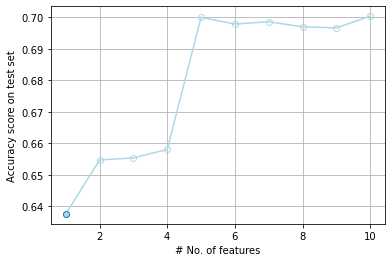

In [184]:
# Estimating accuracy score with test set using RFE using different number of features
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 11):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 11), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')

# Conclusion

To conclude portfolio 3, we will be covering two main points: what needed to be done to prepair the data for use and compatability with the model and the overall accuracy of the model.

In order to prepair the data for use in the model, we needed to do a couple of things. Firstly we needed to drop RECON fields as required. We then dropped data sets with negative age, since this data must be errors as you can't be less than zero years old. Most importantly, we had to drop all fields that had text values as this wouldn't have been able to be read and utilised in the model.

The overall accuracy of the model was quite good but not amazing with around 70% accuracy. We saw very similar results compairing the testing data and the training data having about 1% difference between the two. In reference to how many features would give us the best accuracy, using all 10 features gave us the best accuracy of 70.03% closely followed by 5 features with 70%. We did see a significant increase in accuracy from 5 features and above jumping from 65.80% at 4 features to 70.03% at 5 features. From 5 features and above the accuracy of the model stuck around 69.85% to 70.03%.

In conclusion, the model we used was quite accurate but another models should be experimented with to provide us with more accurate predictions. But, with the current model using 5 or more features and a prime of 10 is sufficient to provide accurate results.